In [1]:
# params
IMAGE_SIZE = 227
NUM_CHANELLS = 3
LEN_FEATURES = IMAGE_SIZE * IMAGE_SIZE * NUM_CHANELLS
NUM_OF_EPOCHS = 30
ZISE_OF_IMAGES = 9000
BATCH_SIZE = 32
LEARNING_RATE = 0.000001
CLASSES = ['happy', 'sad']

# paths
# PATH = r"D:\\Projects\Development\\courses_projects\\deep_learning_and_natural_language_processing\\dog-image-mood-classification"
# PATH_TO_DATA = PATH + '\\' + "data\\images"
# MODEL_HISTORY_FILEPATH = PATH + '\\' + r"models_history\\model_1.hdf5"
DRIVE_PATH = '/content/drive'
PATH = DRIVE_PATH + "/MyDrive/deep-learning/"
PATH_TO_DATA = PATH + "data/images/"
MODEL_HISTORY_FILEPATH = PATH+"RES33/"

In [2]:
from google.colab import drive
drive.mount(DRIVE_PATH)

Mounted at /content/drive


In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "8"

In [4]:
# modeling
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
import cv2

# tools
from typing import Tuple
import os
import random
import numpy as np
from datetime import datetime

# warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [5]:
def load_data(classes) -> Tuple[np.array, np.array]:
  images = []
  labels = []
  files = []
  for i in range(len(classes)):
    folder_name = classes[i]
    path = os.path.join(PATH_TO_DATA, folder_name)
    count = 0
    for file_index, file_name in enumerate(os.listdir(path)):
      file_name = os.path.join(path, file_name)
      image = cv2.imread(file_name)
      image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
      images.append(image)
      label = [i]
      labels.append(label)
      files.append(os.path.join(path, file_name))
      if count == ZISE_OF_IMAGES / 2:
        break
      count += 1
  return np.array(images), np.array(labels)

def plot_images(images, cls_true, cls_pred=None):
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    if cls_pred is not None:
        images, cls_true, cls_pred  = zip(*[(images[i], cls_true[i], cls_pred[i]) for i in random_indices])
    else:
        images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(IMAGE_SIZE, IMAGE_SIZE, 3))

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

def make_vactors(labels) -> np.array:
  new_labels = []
  for label in labels:
      value = label[0]
      new_label = [0] * len(CLASSES)
      new_label[value] = 1
      new_labels.append(new_label)
  return np.array(new_labels)

In [6]:
train_images, train_labels = load_data(CLASSES)
train_images, train_labels = shuffle(train_images, train_labels)

In [7]:
print(f"Shape of training data: {train_images.shape}")

Shape of training data: (9002, 227, 227, 3)


In [8]:
print(f"Size of train: {len(train_images)}")

Size of train: 9002


In [9]:
x_train = train_images.astype('float32') / 255.0
y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))

In [15]:
# AlexNet Model archicture
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(96, (3, 3), strides=(2, 2), padding='valid', activation='relu', input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(tf.keras.layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 2)))



model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.GlobalAveragePooling2D())


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# optimizer = tf.keras.optimizers.Adam()
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 113, 113, 96)      2688      
                                                                 
 batch_normalization_4 (Batc  (None, 113, 113, 96)     384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 256)       221440    
                                                                 
 batch_normalization_5 (Batc  (None, 28, 28, 256)      1024      
 hNormalization)                                                 
                                                      

In [17]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_HISTORY_FILEPATH,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True
    )

train_scores = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_OF_EPOCHS, shuffle=True, validation_split=0.2, callbacks=[model_checkpoint_callback])

Epoch 1/30
226/226 [==============================] - 17s 71ms/step - loss: 0.6565 - accuracy: 0.6116 - val_loss: 0.7155 - val_accuracy: 0.4897
Epoch 2/30
226/226 [==============================] - 15s 65ms/step - loss: 0.6034 - accuracy: 0.6805 - val_loss: 0.7597 - val_accuracy: 0.5125
Epoch 3/30
226/226 [==============================] - 15s 66ms/step - loss: 0.5559 - accuracy: 0.7174 - val_loss: 0.5991 - val_accuracy: 0.6974
Epoch 4/30
226/226 [==============================] - 15s 65ms/step - loss: 0.5262 - accuracy: 0.7399 - val_loss: 0.5250 - val_accuracy: 0.7485
Epoch 5/30
226/226 [==============================] - 13s 57ms/step - loss: 0.4978 - accuracy: 0.7573 - val_loss: 0.5542 - val_accuracy: 0.7335
Epoch 6/30
226/226 [==============================] - 13s 57ms/step - loss: 0.4745 - accuracy: 0.7756 - val_loss: 0.5313 - val_accuracy: 0.7424
Epoch 7/30
226/226 [==============================] - 13s 57ms/step - loss: 0.4500 - accuracy: 0.7946 - val_loss: 0.5714 - val_accuracy:

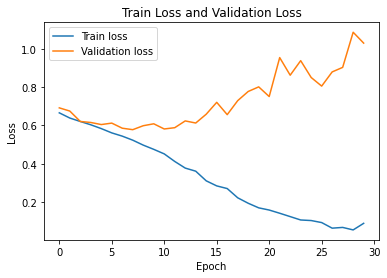

In [13]:
plt.title("Train Loss and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(np.arange(NUM_OF_EPOCHS), train_scores.history['loss'])
plt.plot(np.arange(NUM_OF_EPOCHS), train_scores.history['val_loss'])
plt.legend(["Train loss", "Validation loss"])
plt.show()

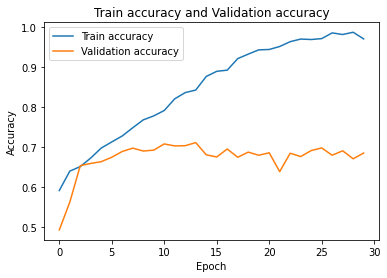

In [14]:
plt.title("Train accuracy and Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(np.arange(NUM_OF_EPOCHS), train_scores.history['accuracy'])
plt.plot(np.arange(NUM_OF_EPOCHS), train_scores.history['val_accuracy'])
plt.legend(["Train accuracy", "Validation accuracy"])
plt.show()